Add scripts folder to path

In [79]:
import sys
sys.path.append("../scripts/")


# Import

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

from fetch_data import DataLoader
from modeling_pipeline import run_train_pipeline
loader = DataLoader()


# Load cleaned data

In [81]:
data = loader.dvc_get_data(path="./data/data.csv",
                        version="cleaned_data",
                        repo="../")
data.shape

DVC: CSV file read with path: ./data/data.csv | version: cleaned_data | from: ../


(569, 31)

In [82]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Split the data

In [83]:
x = data.drop('diagnosis', axis=1)
y = data.diagnosis
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


# Use `SelectKBest` to get the k best features

In [110]:
# find best scored 5 features
num_features = 5
select_feature = SelectKBest(chi2, k=num_features).fit(x_train, y_train)
cols_idx = np.argpartition(select_feature.scores_, -num_features)[-num_features:]
x_train_2 = pd.DataFrame(select_feature.transform(x_train),
                        columns=x_train.columns[cols_idx])

x_test_2 = pd.DataFrame(select_feature.transform(x_test),
                        columns=x_train.columns[cols_idx])
#random forest classifier with n_estimators=10 (default)
x_test_2.columns

Index(['perimeter_mean', 'perimeter_worst', 'area_se', 'area_mean',
       'area_worst'],
      dtype='object')

The above are the columns I will be working with.
Next, I will be testing them on a model

Run params saved
Run metrics saved
figures saved
Run - RFClassifier with 5 features is logged to Experiment - Feature Selection


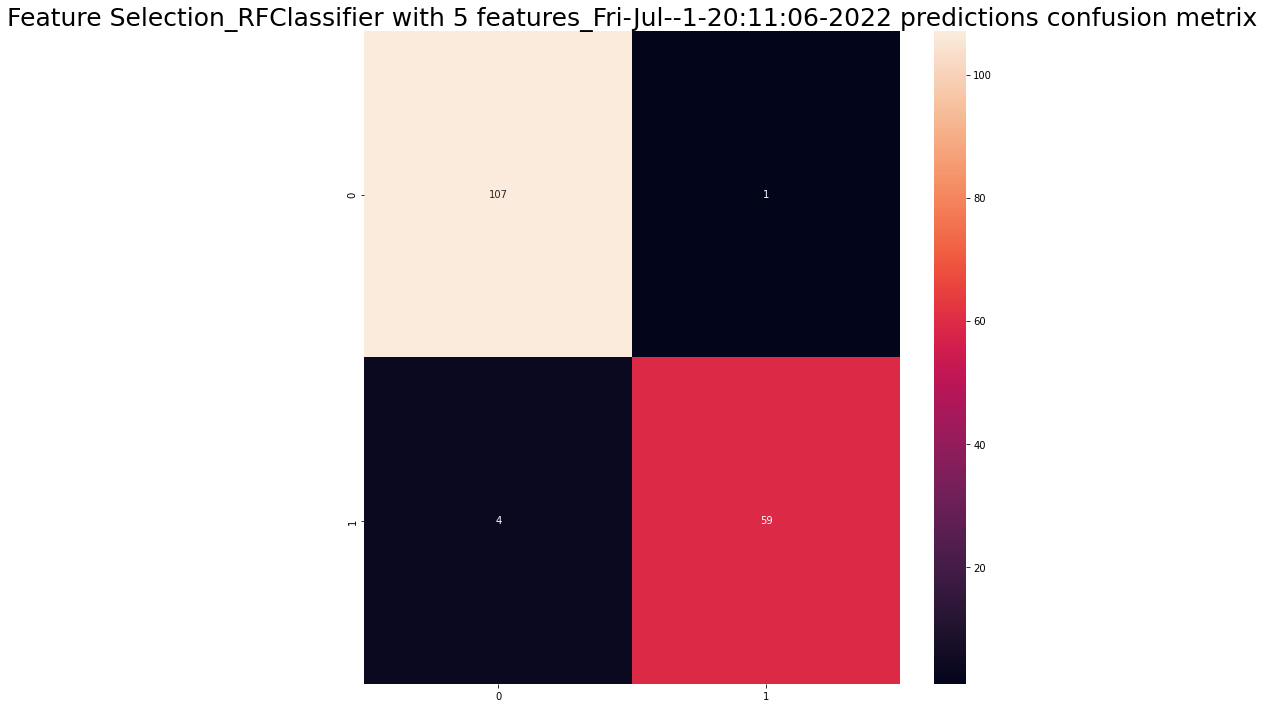

In [111]:
clf_rf = RandomForestClassifier(random_state=5, n_jobs=4)
run_ret = run_train_pipeline(
    model=clf_rf,
    x_train=x_train_2,
    y_train=y_train,
    x_test=x_test_2,
    y_test=y_test,
    experiment_name="Feature Selection",
    run_name=f"RFClassifier with {num_features} features",
)

In [107]:
run_ret["metrics"]

{'mse': 0.03, 'r2': 0.87, 'mae': 0.03, 'ac': 0.97}

I have run this with multiple configurations and the best accuracy is 97%. For the log of the training, you can look at the mlflow logs.